This code runs the ordinal model analysis of the first clips from each observation.

In [10]:
# Load packages
#install.packages("ordinal", lib = "/Users/blaircostelloe/opt/anaconda3/envs/disturbance-paper/lib/R/library", repos='http://cran.us.r-project.org')
#install.packages("sure", lib = "//Users/blaircostelloe/opt/anaconda3/envs/disturbance-paper/lib/R/library", repos='http://cran.us.r-project.org')
#install.packages("car", lib = "/Users/blaircostelloe/opt/anaconda3/envs/disturbance-paper/lib/R/library", repos='http://cran.us.r-project.org')
require(ordinal, lib.loc = "/Users/blaircostelloe/opt/anaconda3/envs/disturbance-paper/lib/R/library")
require(sure, lib.loc = "/Users/blaircostelloe/opt/anaconda3/envs/disturbance-paper/lib/R/library")
require(car, lib.loc = "/Users/blaircostelloe/opt/anaconda3/envs/disturbance-paper/lib/R/library")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
also installing the dependencies ‘goftest’, ‘gridExtra’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
also installing the dependencies ‘Rcpp’, ‘matrixStats’, ‘RcppArmadillo’, ‘zip’, ‘SparseM’, ‘MatrixModels’, ‘conquer’, ‘sp’, ‘openxlsx’, ‘minqa’, ‘nloptr’, ‘statmod’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘pbkrtest’, ‘quantreg’, ‘maptools’, ‘rio’, ‘lme4’

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: sure
Loading required package: car
Loading required package: carData


In [11]:
# Load and set up data
df <- read.csv("data/first_clips.csv")

# Change group_behavior to an ordered factor
df$group_behavior <-factor(df$group_behavior, ordered = TRUE)

# Define order of categorical variables
df$young_present <-factor(df$young_present, levels = c('False', 'True'))
df$site <-factor(df$site, levels = c('mpala', 'opc'))
df$species <-factor(df$species, levels = c('imp', 'pz', 'gz', 'buf'))

# Drop unneeded variables
df <-subset(df, select = -c(date, obs_ascent, approach_speed_mean,
                           approach_speed_max, approach_duration_minutes,
                           exchange_duration, takeoff_time, landing_time, 
                           temperature_c, max_windspeed, cloud_cover_., humidity_., group_downwind))

For the first step, I want to include the effect of habitat bushiness, which is not available for observations from the Ol Pejeta (opc) field site. So I keep only data from the mpala field site. I also drop buffalo since they have no 0 scores (and thus prevent the model from converging).

I standardize the numerical variables by subtracting the mean value and dividing by the standard deviation.

There were very few response level 3s, so I combine response levels 2 and 3.

In [22]:
mpala <-df[(df$site == 'mpala'),]
mpala <-mpala[!(mpala$species == 'buf'),]

# drop rows with missing data
mpala <- mpala[complete.cases(mpala),]

# standardize numerical variables
mpala$group_size_spp <- (mpala$group_size_spp - mean(mpala$group_size_spp))/sd(mpala$group_size_spp)
mpala$group_size_total <- (mpala$group_size_total - mean(mpala$group_size_total))/sd(mpala$group_size_total)
mpala$bushiness_100m <- (mpala$bushiness_100m - mean(mpala$bushiness_100m))/sd(mpala$bushiness_100m)
mpala$clip_start_ascent_adj <- (mpala$clip_start_ascent_adj - mean(mpala$clip_start_ascent_adj))/sd(mpala$clip_start_ascent_adj)
mpala$mean_windspeed <- (mpala$mean_windspeed - mean(mpala$mean_windspeed))/sd(mpala$mean_windspeed)
mpala$launch_dist <- (mpala$launch_dist - mean(mpala$launch_dist))/sd(mpala$launch_dist)
mpala$wind_speed_ms <- (mpala$wind_speed_ms - mean(mpala$wind_speed_ms))/sd(mpala$wind_speed_ms)

# combine response levels 2 & 3
mpala$group_behavior[mpala$group_behavior ==3] <-2

# drop unneeded levels
mpala <- droplevels(mpala)
summary(mpala)

  observation    site        flight   species  group_size_spp   
 ob110  : 3   mpala:87   110-01 : 3   imp:46   Min.   :-1.2017  
 ob015  : 2              015-01 : 2   pz :21   1st Qu.:-0.8509  
 ob016  : 2              016-01 : 2   gz :20   Median :-0.3597  
 ob036  : 2              036-01 : 2            Mean   : 0.0000  
 ob042  : 2              042-01 : 2            3rd Qu.: 0.6226  
 ob043  : 2              043-01 : 2            Max.   : 2.9381  
 (Other):74              (Other):74                             
 group_size_total  young_present group_behavior  launch_dist     
 Min.   :-1.2683   False:38      0:51           Min.   :-1.2039  
 1st Qu.:-0.8331   True :49      1:20           1st Qu.:-0.6705  
 Median :-0.1801                 2:16           Median :-0.2797  
 Mean   : 0.0000                                Mean   : 0.0000  
 3rd Qu.: 0.6179                                3rd Qu.: 0.4061  
 Max.   : 2.7218                                Max.   : 3.2605  
                  

Build the initial full model.

In [13]:
M1 <- clm(group_behavior ~ other_spp + group_size_spp + young_present + bushiness_100m +
          clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed + species,
          data = mpala)
summary(M1)

formula: 
group_behavior ~ other_spp + group_size_spp + young_present + bushiness_100m + clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed + species
data:    mpala

 link  threshold nobs logLik AIC    niter max.grad cond.H 
 logit flexible  87   -72.33 168.67 4(0)  3.69e-07 4.7e+01

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)   
other_sppTrue          0.02951    0.55377   0.053  0.95751   
group_size_spp         0.33958    0.32895   1.032  0.30191   
young_presentTrue     -0.37287    0.55470  -0.672  0.50146   
bushiness_100m        -0.35075    0.32111  -1.092  0.27470   
clip_start_ascent_adj -0.46075    0.33499  -1.375  0.16900   
launch_dist           -0.65781    0.35795  -1.838  0.06610 . 
wind_speed_ms          0.35921    0.28520   1.259  0.20786   
mean_windspeed        -0.38925    0.27450  -1.418  0.15618   
speciespz              2.43015    0.84848   2.864  0.00418 **
speciesgz              2.18457    0.78465   2.784  0.00537 **
-

Perform model validation by inspecting surrogate residuals

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


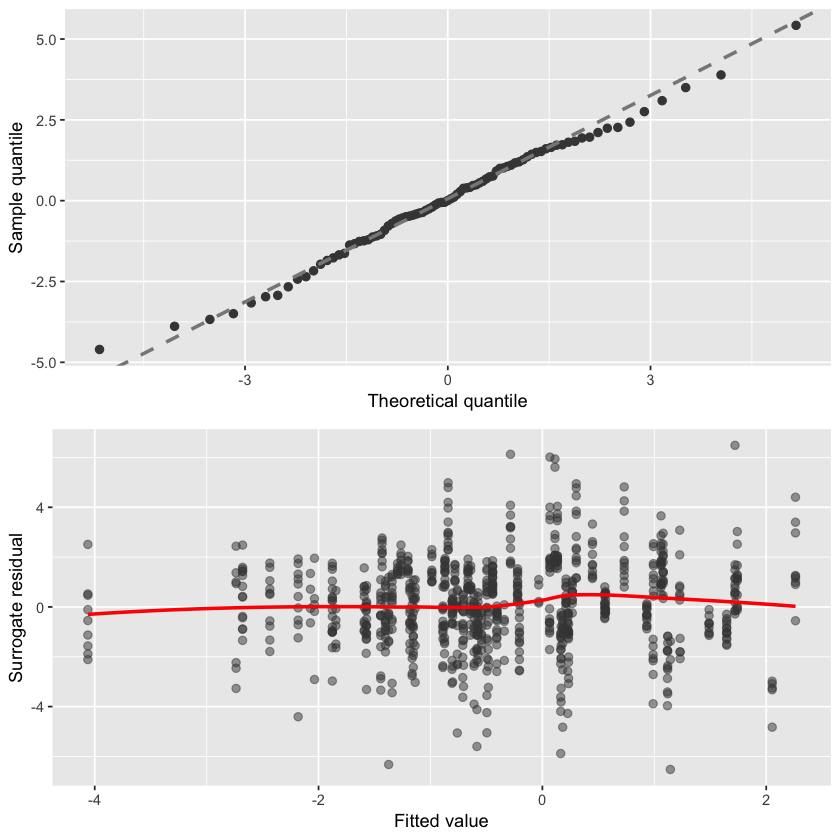

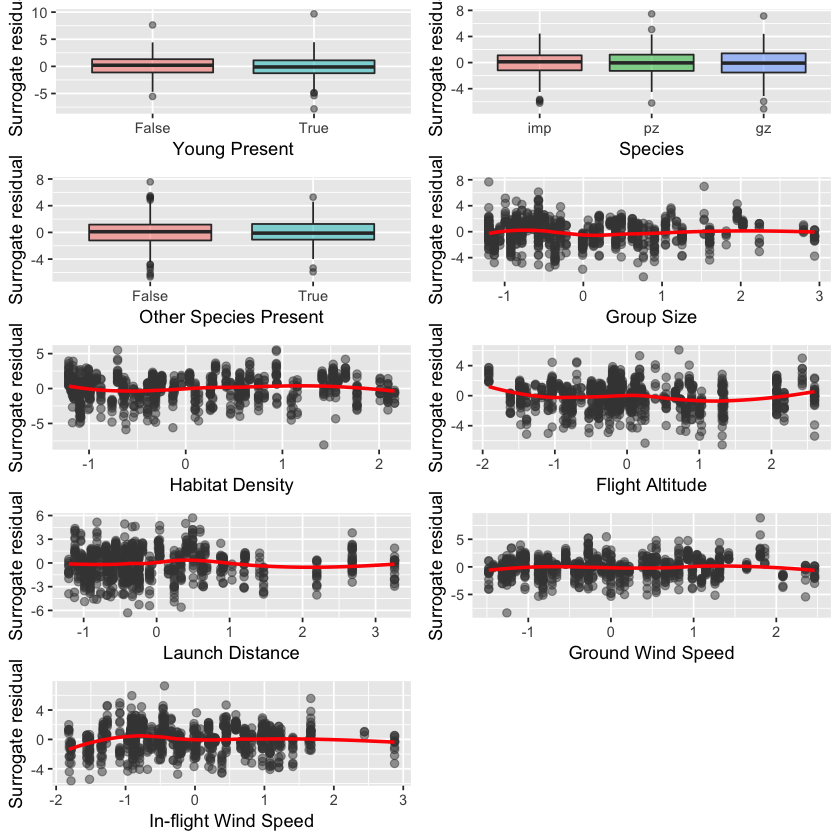

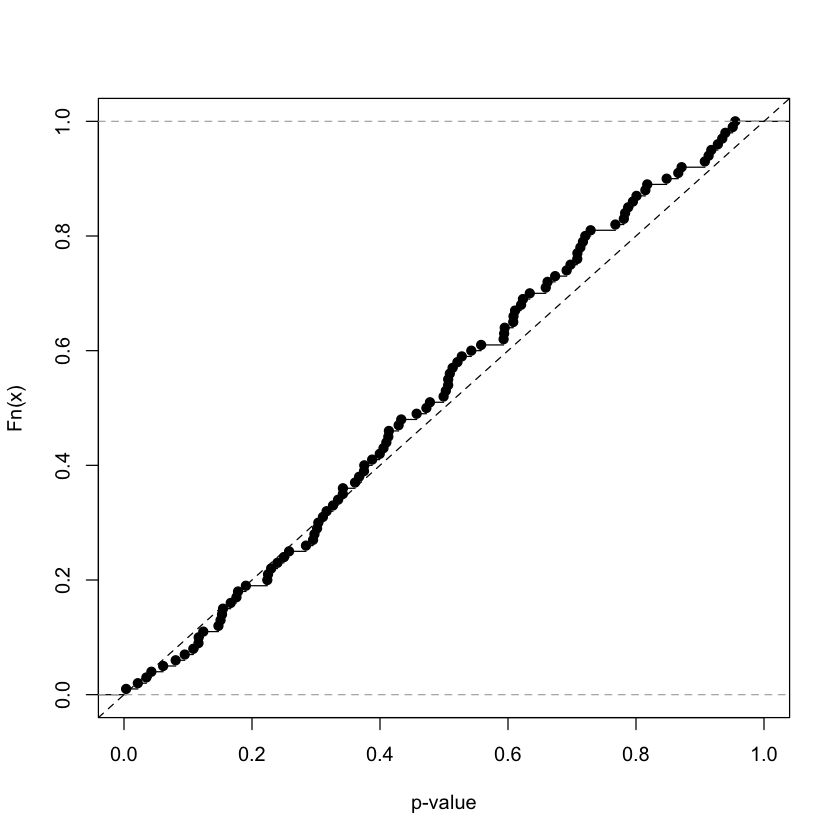

In [14]:
set.seed(1000)
# plot qq plot of residuals and plot residuals by fitted values
grid.arrange(autoplot.clm(M1, nsim = 10, what = 'qq'),
             autoplot.clm(M1, nsim = 10, what = 'fitted', alpha = 0.5),
             ncol = 1)

grid.arrange(
     autoplot.clm(M1, nsim = 10, what = 'covariate', x = mpala$young_present, xlab = 'Young Present', alpha = 0.5),
     autoplot.clm(M1, nsim = 10, what = 'covariate', x = mpala$species, xlab = 'Species', alpha = 0.5),
     autoplot.clm(M1, nsim = 10, what = 'covariate', x = mpala$other_spp, xlab = 'Other Species Present', alpha = 0.5),
     autoplot.clm(M1, nsim = 10, what = 'covariate', x = mpala$group_size_spp, xlab = 'Group Size', alpha = 0.5),
     autoplot.clm(M1, nsim = 10, what = 'covariate', x = mpala$bushiness_100m, xlab = 'Habitat Density', alpha = 0.5),
     autoplot.clm(M1, nsim = 10, what = 'covariate', x = mpala$clip_start_ascent_adj, xlab = 'Flight Altitude', alpha = 0.5),
     autoplot.clm(M1, nsim = 10, what = 'covariate', x = mpala$launch_dist, xlab = 'Launch Distance', alpha = 0.5),
     autoplot.clm(M1, nsim = 10, what = 'covariate', x = mpala$wind_speed_ms, xlab = 'Ground Wind Speed', alpha = 0.5),
     autoplot.clm(M1, nsim = 10, what = 'covariate', x = mpala$mean_windspeed, xlab = 'In-flight Wind Speed', alpha = 0.5),
     ncol = 2
)

# Kolmogorov-Smirnov goodness-of-fit test.
plot(gof(M1, nsim = 100, test = "ks"), main = "")

Validate the model assumptions (proportional odds assumption and no collinearity)

In [15]:
nominal_test(M1)

,Df,logLik,AIC,LRT,Pr(>Chi)
<none>,NA,-72.33373,168.6675,NA,NA
other_spp,1,-71.63821,169.2764,1.39104114,0.23822935
group_size_spp,1,-70.73146,167.4629,3.20453783,0.07343425
young_present,1,-72.30058,170.6012,0.06628587,0.79682336
bushiness_100m,1,-71.84446,169.6889,0.97852447,0.32256336
clip_start_ascent_adj,1,-71.29785,168.5957,2.07175086,0.15004918
launch_dist,1,-72.19591,170.3918,0.27563354,0.59957754
wind_speed_ms,1,-72.21209,170.4242,0.24326554,0.62185746
mean_windspeed,1,-71.96149,169.9230,0.74448096,0.38822924
species,2,-68.85959,165.7192,6.94826634,0.03098868


The nominal test indicates that species and possibly group size violate the proportional odds assumption (POA). This needs to be examined directly.
We build two separate binary logistic regression models, one for each response threshold, so we can look at the odds ratios and assess whether they are consistent for each variable across thresholds.

In [16]:
# create binarized response variables
mpala$response0vs12 <- ifelse(mpala$group_behavior == 0, 0, 1)
mpala$response01vs2 <- ifelse(mpala$group_behavior == 2, 1, 0)

bin0vs12 <- glm(response0vs12 ~ group_size_spp + other_spp + young_present + bushiness_100m
                + clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed
                + species, family = binomial(link = 'logit'), data = mpala)
bin01vs2 <- glm(response01vs2 ~ group_size_spp + other_spp + young_present + bushiness_100m
                + clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed
                + species, family = binomial(link = 'logit'), data = mpala)

summary(bin0vs12)
summary(bin01vs2)


Call:
glm(formula = response0vs12 ~ group_size_spp + other_spp + young_present + 
    bushiness_100m + clip_start_ascent_adj + launch_dist + wind_speed_ms + 
    mean_windspeed + species, family = binomial(link = "logit"), 
    data = mpala)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0450  -0.9372  -0.4971   1.0433   1.8403  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)  
(Intercept)            -1.1960     0.5240  -2.282   0.0225 *
group_size_spp          0.3869     0.3638   1.064   0.2875  
other_sppTrue          -0.1209     0.5899  -0.205   0.8376  
young_presentTrue      -0.2800     0.5794  -0.483   0.6290  
bushiness_100m         -0.3947     0.3277  -1.204   0.2284  
clip_start_ascent_adj  -0.4756     0.3300  -1.441   0.1496  
launch_dist            -0.6278     0.3666  -1.712   0.0868 .
wind_speed_ms           0.2178     0.2901   0.751   0.4529  
mean_windspeed         -0.2532     0.2827  -0.896   0.3705  
speciespz         


Call:
glm(formula = response01vs2 ~ group_size_spp + other_spp + young_present + 
    bushiness_100m + clip_start_ascent_adj + launch_dist + wind_speed_ms + 
    mean_windspeed + species, family = binomial(link = "logit"), 
    data = mpala)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5595  -0.5199  -0.2681  -0.1593   2.4434  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -3.9216     1.0306  -3.805 0.000142 ***
group_size_spp          0.4037     0.5709   0.707 0.479442    
other_sppTrue           0.4213     0.7269   0.580 0.562215    
young_presentTrue      -0.1879     0.7851  -0.239 0.810865    
bushiness_100m         -0.1730     0.4341  -0.398 0.690318    
clip_start_ascent_adj  -0.3571     0.4516  -0.791 0.429019    
launch_dist            -0.8415     0.5703  -1.476 0.140017    
wind_speed_ms           0.5140     0.4060   1.266 0.205457    
mean_windspeed         -0.6410     0.4274  -1.500 0.133674   

To get the odds ratios we exponentiate the coefficient estimates (logits)

In [17]:
OR_0vs12 <- exp(coef(bin0vs12))
OR_01vs2 <- exp(coef(bin01vs2))
data.frame(OR_0vs12, OR_01vs2)

,OR_0vs12,OR_01vs2
(Intercept),0.3024165,0.0198087
group_size_spp,1.4724494,1.4974149
other_sppTrue,0.8861181,1.5239033
young_presentTrue,0.7558187,0.8287166
bushiness_100m,0.6738854,0.8411601
clip_start_ascent_adj,0.6215294,0.6996810
launch_dist,0.5337741,0.4310468
wind_speed_ms,1.2432898,1.6719942
mean_windspeed,0.7763009,0.5267674
speciespz,10.2253631,31.7160958


The odds ratios for species are drastically different between the two models. Therefore, we create a partial proportional odds model with the POA relaxed for the species variable.

In [18]:
M1.2 <- clm(group_behavior ~ group_size_spp + other_spp + young_present + bushiness_100m +
            clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed,
            nominal = ~ species,
            data = mpala)
summary(M1.2)

formula: 
group_behavior ~ group_size_spp + other_spp + young_present + bushiness_100m + clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed
nominal: ~species
data:    mpala

 link  threshold nobs logLik AIC    niter max.grad cond.H 
 logit flexible  87   -68.86 165.72 6(1)  4.88e-11 1.6e+02

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)  
group_size_spp         0.36780    0.33388   1.102    0.271  
other_sppTrue         -0.07156    0.55069  -0.130    0.897  
young_presentTrue     -0.33337    0.55163  -0.604    0.546  
bushiness_100m        -0.28139    0.32023  -0.879    0.380  
clip_start_ascent_adj -0.49492    0.34178  -1.448    0.148  
launch_dist           -0.59255    0.35919  -1.650    0.099 .
wind_speed_ms          0.35077    0.28213   1.243    0.214  
mean_windspeed        -0.39474    0.27589  -1.431    0.152  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Threshold coefficients:
                Estimate Std. Erro

In [19]:
nominal_test(M1.2)

,Df,logLik,AIC,LRT,Pr(>Chi)
<none>,NA,-68.85959,165.7192,NA,NA
group_size_spp,1,-68.70153,167.4031,0.31612852,0.573943604
other_spp,NA,NA,NA,NA,NA
young_present,1,-68.84555,167.6911,0.02809306,0.866890224
bushiness_100m,1,-65.37161,160.7432,6.97597446,0.008261123
clip_start_ascent_adj,1,-68.67173,167.3435,0.37571876,0.539903438
launch_dist,1,-67.98786,165.9757,1.74347253,0.186699435
wind_speed_ms,1,-68.76563,167.5313,0.18792557,0.664648788
mean_windspeed,NA,NA,NA,NA,NA


Bushiness fails the nominal test, but examination of the odds ratios for the binary logistic models does not indicate that relaxing the POA for these variables is warranted.

To test for multicollinearity among the predictor varaibles, we create a linear regression model with a dummy numerical response variable and then run the VIF (variance inflation factor) test.

In [20]:
mpala$group_behavior_num <- as.numeric(mpala$group_behavior)

lmfit <- lm(group_behavior_num ~ group_size_spp + other_spp + young_present + launch_dist +
            bushiness_100m + clip_start_ascent_adj + wind_speed_ms + mean_windspeed +
            species, data = mpala)

vif(lmfit)

,GVIF,Df,GVIF^(1/(2*Df))
group_size_spp,2.112809,1,1.453550
other_spp,1.359797,1,1.166103
young_present,1.461752,1,1.209029
launch_dist,1.923650,1,1.386957
bushiness_100m,1.787850,1,1.337105
clip_start_ascent_adj,1.727605,1,1.314384
wind_speed_ms,1.554101,1,1.246636
mean_windspeed,1.429868,1,1.195771
species,2.528860,2,1.261047


No values in the last column are over 2, so there is no violation of multicollinearity (source: https://stats.stackexchange.com/questions/70679/which-variance-inflation-factor-should-i-be-using-textgvif-or-textgvif).

So the final model is M1.2

The bushiness variable does not have a significant effect in M1.2. Therefore, we will run another model that doesn't include bushiness so that we can keep some of the data we discarded earlier (data from Ol Pejeta and from Mpala observations that had no landscape maps).

First, we'll clean up the dataframe.

In [21]:
df2 <-df[!(df$species =='buf'),]

# drop unneeded variables
df2 <- subset(df2, select = -bushiness_100m)

# drop rows with missing data
df2 <- df2[complete.cases(df2),]

# standardize numerical variables
df2$group_size_spp <- (df2$group_size_spp - mean(df2$group_size_spp))/sd(df2$group_size_spp)
df2$group_size_total <- (df2$group_size_total - mean(df2$group_size_total))/sd(df2$group_size_total)
df2$clip_start_ascent_adj <- (df2$clip_start_ascent_adj - mean(df2$clip_start_ascent_adj))/sd(df2$clip_start_ascent_adj)
df2$mean_windspeed <- (df2$mean_windspeed - mean(df2$mean_windspeed))/sd(df2$mean_windspeed)
df2$launch_dist <- (df2$launch_dist - mean(df2$launch_dist))/sd(df2$launch_dist)
df2$wind_speed_ms <- (df2$wind_speed_ms - mean(df2$wind_speed_ms))/sd(df2$wind_speed_ms)

# combine response levels 2 & 3
df2$group_behavior[df2$group_behavior ==3] <-2

# drop unneeded levels
df2 <- droplevels(df2)

summary(df2)

  observation    site        flight   species  group_size_spp   
 ob110  : 3   mpala:90   110-01 : 3   imp:51   Min.   :-1.1905  
 ob015  : 2   opc  : 9   015-01 : 2   pz :28   1st Qu.:-0.8296  
 ob016  : 2              016-01 : 2   gz :20   Median :-0.3244  
 ob036  : 2              036-01 : 2            Mean   : 0.0000  
 ob042  : 2              042-01 : 2            3rd Qu.: 0.6139  
 ob043  : 2              043-01 : 2            Max.   : 3.0678  
 (Other):86              (Other):86                             
 group_size_total  young_present group_behavior  launch_dist     
 Min.   :-1.3995   False:47      0:57           Min.   :-1.2188  
 1st Qu.:-0.8036   True :52      1:22           1st Qu.:-0.7034  
 Median :-0.2822                 2:20           Median :-0.3199  
 Mean   : 0.0000                                Mean   : 0.0000  
 3rd Qu.: 0.6117                                3rd Qu.: 0.4744  
 Max.   : 2.8463                                Max.   : 3.0954  
                  

Build the model

In [23]:
M2 <- clm(group_behavior ~ group_size_spp + other_spp + young_present + site +
          clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed + species,
          data = df2)
summary(M2)

formula: 
group_behavior ~ group_size_spp + other_spp + young_present + site + clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed + species
data:    df2

 link  threshold nobs logLik AIC    niter max.grad cond.H 
 logit flexible  99   -86.02 196.05 4(0)  6.79e-08 4.1e+01

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
group_size_spp          0.3319     0.2963   1.120 0.262658    
other_sppTrue          -0.1300     0.4902  -0.265 0.790783    
young_presentTrue      -0.5592     0.5062  -1.105 0.269274    
siteopc                 0.1425     0.8488   0.168 0.866674    
clip_start_ascent_adj  -0.3209     0.3059  -1.049 0.294124    
launch_dist            -0.5805     0.3075  -1.888 0.059038 .  
wind_speed_ms           0.2359     0.2531   0.932 0.351338    
mean_windspeed         -0.2096     0.2520  -0.832 0.405386    
speciespz               2.5821     0.6726   3.839 0.000123 ***
speciesgz               1.9334     0.7192   2.688 0.007183 ** 
--

Perform model validation by inspecting surrogate residuals

`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


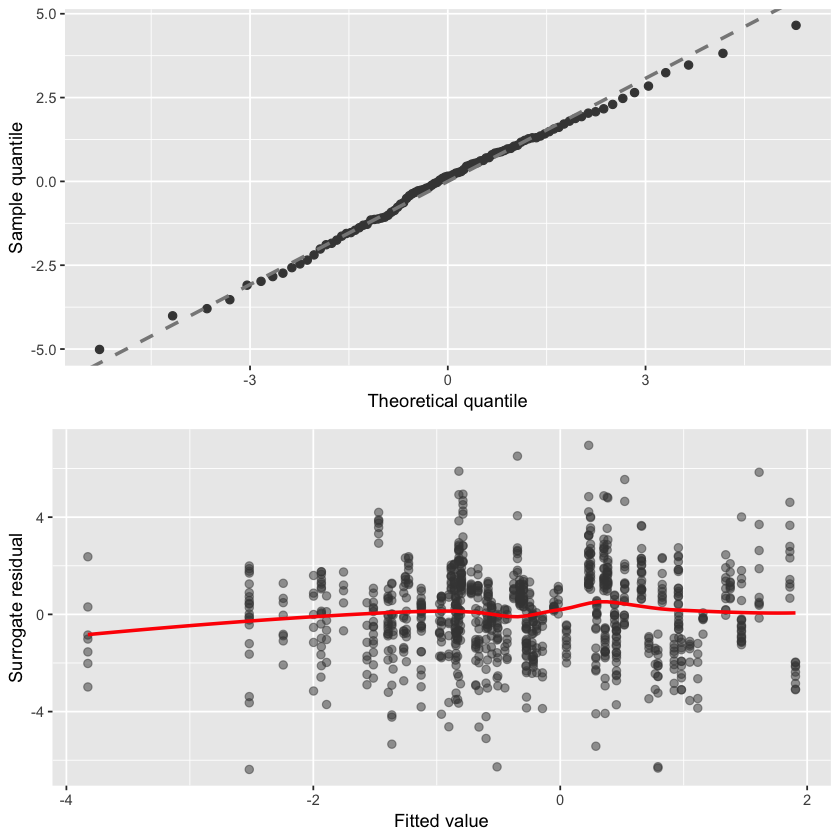

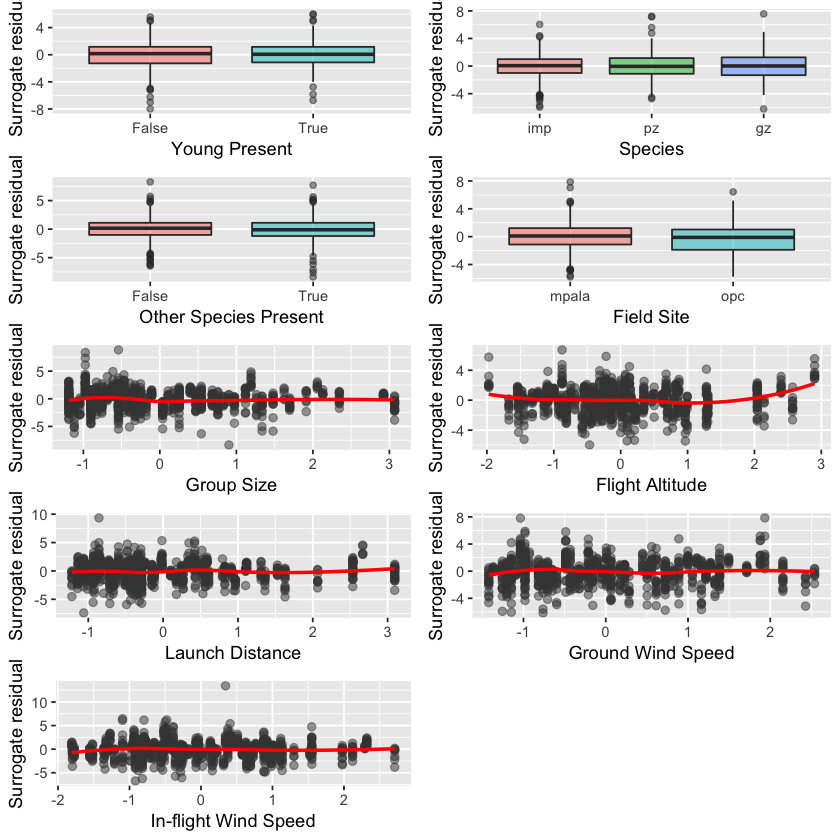

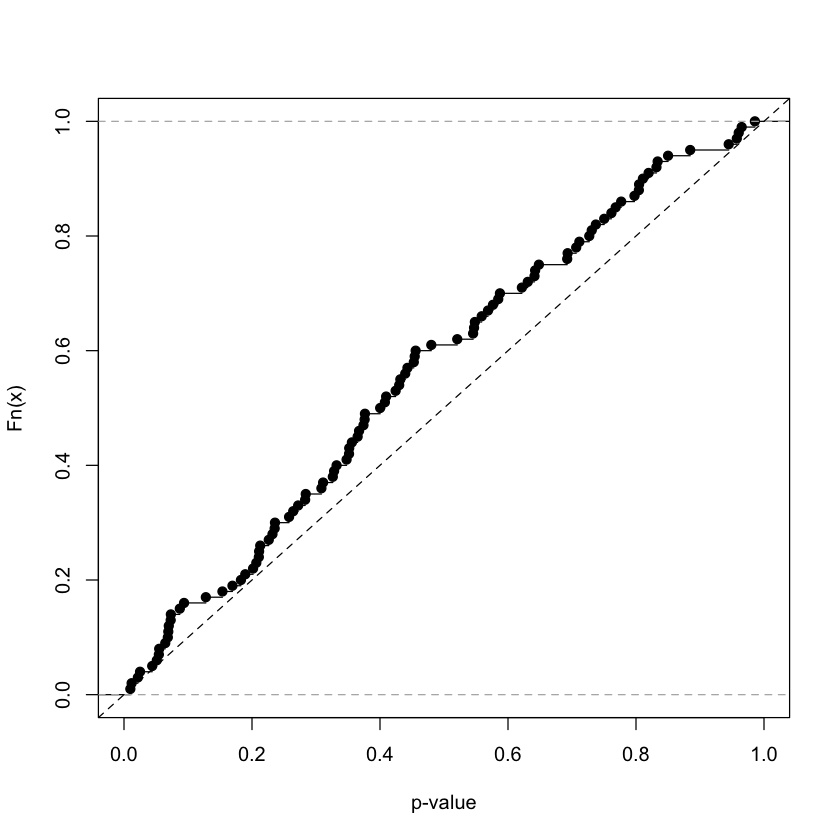

In [24]:
set.seed(1000) # for reproducibility
# plot qq plot of residuals and plot residuals by fitted values
grid.arrange(
  autoplot.clm(M2, nsim = 10, what = 'qq'),
  autoplot.clm(M2, nsim = 10, what = 'fitted', alpha = 0.5),
  ncol = 1
)

grid.arrange(
     autoplot.clm(M2, nsim = 10, what = 'covariate', x = df2$young_present, xlab = 'Young Present', alpha = 0.5),
     autoplot.clm(M2, nsim = 10, what = 'covariate', x = df2$species, xlab = 'Species', alpha = 0.5),
     autoplot.clm(M2, nsim = 10, what = 'covariate', x = df2$other_spp, xlab = 'Other Species Present', alpha = 0.5),
     autoplot.clm(M2, nsim = 10, what = 'covariate', x = df2$site, xlab = 'Field Site', alpha = 0.5),
     autoplot.clm(M2, nsim = 10, what = 'covariate', x = df2$group_size_spp, xlab = 'Group Size', alpha = 0.5),
     autoplot.clm(M2, nsim = 10, what = 'covariate', x = df2$clip_start_ascent_adj, xlab = 'Flight Altitude', alpha = 0.5),
     autoplot.clm(M2, nsim = 10, what = 'covariate', x = df2$launch_dist, xlab = 'Launch Distance', alpha = 0.5),
     autoplot.clm(M2, nsim = 10, what = 'covariate', x = df2$wind_speed_ms, xlab = 'Ground Wind Speed', alpha = 0.5),
     autoplot.clm(M2, nsim = 10, what = 'covariate', x = df2$mean_windspeed, xlab = 'In-flight Wind Speed', alpha = 0.5),
     ncol = 2
)

# Kolmogorov-Smirnov goodness-of-fit test.
plot(gof(M2, nsim = 100, test = "ks"), main = "")

Check POA and multicollinearity

In [25]:
nominal_test(M2)

,Df,logLik,AIC,LRT,Pr(>Chi)
<none>,NA,-86.02278,196.0456,NA,NA
group_size_spp,1,-84.28049,194.5610,3.484566347,0.06194359
other_spp,1,-85.09003,196.1801,1.865486973,0.17199286
young_present,1,-85.98169,197.9634,0.082176493,0.77436928
site,1,-85.38483,196.7697,1.275888548,0.25866489
clip_start_ascent_adj,1,-84.59242,195.1848,2.860721130,0.09076680
launch_dist,1,-86.02222,198.0444,0.001123969,0.97325541
wind_speed_ms,1,-85.95013,197.9003,0.145294724,0.70307306
mean_windspeed,1,-85.87112,197.7422,0.303306530,0.58181691
species,2,-82.78187,193.5637,6.481821343,0.03912825


Possible violation of the POA by group_size_spp and species.
We build two binary logistic regression models so we can look at the odds ratios and assess whether they are consistent for each variable across thresholds.

In [26]:
df2$response0vs12 <- ifelse(df2$group_behavior == 0, 0, 1)
df2$response01vs2 <- ifelse(df2$group_behavior == 2, 1, 0)

bin0vs12_M2 <- glm(response0vs12 ~ group_size_spp + other_spp + young_present + site +
                   clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed +
                   species, family = binomial(link = 'logit'), data = df2)

bin01vs2_M2 <- glm(response01vs2 ~ group_size_spp + other_spp + young_present + site +
                   clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed +
                   species, family = binomial(link = 'logit'), data = df2)

OR_0vs12_M2 <- exp(coef(bin0vs12_M2))
OR_01vs2_M2 <- exp(coef(bin01vs2_M2))

data.frame(OR_0vs12_M2, OR_01vs2_M2)

,OR_0vs12_M2,OR_01vs2_M2
(Intercept),0.3727833,0.04427963
group_size_spp,1.4331161,1.31185589
other_sppTrue,0.7744547,1.18886798
young_presentTrue,0.5962054,0.61760895
siteopc,0.8327244,2.10702920
clip_start_ascent_adj,0.7091651,0.90314585
launch_dist,0.6131051,0.47681909
wind_speed_ms,1.1975503,1.20510499
mean_windspeed,0.8636790,0.74754660
speciespz,12.0947678,18.50893977


Species and site seem to be in violation. Site is likely a result of the uneven sample size between the two locations. Let's make a partial proportional odds model with the POA relaxed for species

In [27]:
M2.2 <- clm(group_behavior ~ group_size_spp + other_spp + young_present + site +
            clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed,
            nominal = ~ species, data = df2)

nominal_test(M2.2)

,Df,logLik,AIC,LRT,Pr(>Chi)
<none>,NA,-82.78187,193.5637,NA,NA
group_size_spp,1,-82.46018,194.9204,0.643377975,0.4224902
other_spp,NA,NA,NA,NA,NA
young_present,1,-82.71270,195.4254,0.138324341,0.7099526
site,NA,NA,NA,NA,NA
clip_start_ascent_adj,1,-82.41148,194.8230,0.740780653,0.3894109
launch_dist,1,-82.36235,194.7247,0.839033161,0.3596734
wind_speed_ms,1,-82.78145,195.5629,0.000840133,0.9768765
mean_windspeed,1,-82.01595,194.0319,1.531831258,0.2158378


There are no values here for site and other_spp because when these variables are set as nominal variables, the odds models do not converge. The models "test" below is M2.2 without these variables. We ran an ANOVA comparison of the models to see if removing these variables has a positive effect on the model. The model is not improved with their removal.

In [28]:
test <- clm(group_behavior ~ group_size_spp + young_present +
            clip_start_ascent_adj + launch_dist + wind_speed_ms +
            mean_windspeed,
            nominal = ~ species, 
            data = df2)
anova(M2.2, test)

,no.par,AIC,logLik,LR.stat,df,Pr(>Chisq)
test,12,189.7209,-82.86047,NA,NA,NA
M2.2,14,193.5637,-82.78187,0.157198,2,0.9244105


Test for multicoliniearity using the linear regression model with dummy numerical response.

In [29]:
df2$group_response_num <- as.numeric(df2$group_behavior)

lmfit2 <-lm(group_response_num ~ group_size_spp + other_spp + young_present + launch_dist +
            site + clip_start_ascent_adj + wind_speed_ms + mean_windspeed + species,
            data = df2)

vif(lmfit2)

,GVIF,Df,GVIF^(1/(2*Df))
group_size_spp,2.039838,1,1.428229
other_spp,1.354263,1,1.163728
young_present,1.469332,1,1.212160
launch_dist,1.692561,1,1.300985
site,1.278323,1,1.130630
clip_start_ascent_adj,1.817591,1,1.348181
wind_speed_ms,1.495593,1,1.222944
mean_windspeed,1.371559,1,1.171136
species,2.070129,2,1.199498


No issues with multicolinearity, so we accept model M2.2 as our final model.

In [30]:
summary(M2.2)

formula: 
group_behavior ~ group_size_spp + other_spp + young_present + site + clip_start_ascent_adj + launch_dist + wind_speed_ms + mean_windspeed
nominal: ~species
data:    df2

 link  threshold nobs logLik AIC    niter max.grad cond.H 
 logit flexible  99   -82.78 193.56 5(1)  6.18e-07 1.2e+02

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)  
group_size_spp          0.3347     0.2984   1.122   0.2620  
other_sppTrue          -0.1728     0.4885  -0.354   0.7235  
young_presentTrue      -0.5374     0.5031  -1.068   0.2854  
siteopc                 0.1170     0.8408   0.139   0.8893  
clip_start_ascent_adj  -0.3290     0.3075  -1.070   0.2846  
launch_dist            -0.5496     0.3080  -1.784   0.0744 .
wind_speed_ms           0.2283     0.2525   0.904   0.3660  
mean_windspeed         -0.2140     0.2525  -0.848   0.3967  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Threshold coefficients:
                Estimate Std. Error z value
0|